# Analysis of the Temporal Evolution of Loads by State

This notebook analyzes the time series of annual total and peak loads from TELL by state.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_tbd/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_tbd/figures/States/'


## Process the TELL Output Files

In [3]:
# Check to see if the processed output file exist and if not then create it:
if os.path.isfile((os.path.join(data_output_dir, 'State_Load_Time_Series.csv'))) == False:

   # Set the scenarios to process:
   scenarios = ['historic', 'rcp45cooler_ssp3', 'rcp45cooler_ssp5', 'rcp45hotter_ssp3', 'rcp45hotter_ssp5', 'rcp85cooler_ssp3', 'rcp85cooler_ssp5', 'rcp85hotter_ssp3', 'rcp85hotter_ssp5']

   #Initiate a counter and empty dataframe to store the results:
   counter = 0;
   output_df = pd.DataFrame()

   # Loop over the scenarios and process each time series:
   for s in range(len(scenarios)):
       if scenarios[s] == 'historic':
          start_year = 1980; end_year = 2020; interval = 1
       else:
          start_year = 2020; end_year = 2100; interval = 5
        
       # Loop over the years from the start_year to the end_year in 5-year increments:
       for year in range(start_year,end_year,interval):
           # Read in the TELL BA output file for that year and scenario:
           tell_df = pd.read_csv(data_input_dir + 'outputs/tell_output/' + scenarios[s] + '/' + str(year) + '/TELL_State_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
             
           # Make a list of all of the states in the 'merged_df':
           states = tell_df['State_Name'].unique()
         
           # Loop over the states and calculate the total and peak load for each year:
           for i in range(len(states)):
               # Iterate the counter by one:
               counter = counter + 1
            
               # Subset to just the data for the state being processed:
               subset_df = tell_df[tell_df['State_Name'].isin([states[i]])].copy()
          
               # Put the output in a new dataframe:
               output_df.loc[counter, 'Scenario'] = scenarios[s]
               output_df.loc[counter, 'Year'] = int(year)
               output_df.loc[counter, 'State'] = states[i]
               output_df.loc[counter, 'Total_Load_TWh'] = (subset_df['Scaled_TELL_State_Load_MWh'].sum().round(6)) / 1000000
               output_df.loc[counter, 'Peak_Load_MWh'] = subset_df['Scaled_TELL_State_Load_MWh'].max()
            
               # Clean up
               del subset_df

           # Clean up
           del tell_df, states
         
   # Initiate an empty normalized load variable:
   output_df['Total_Load_Normalized'] = np.nan
   output_df['Peak_Load_Normalized'] = np.nan

   # Loop over the rows of the dataframe normalize the load by the base year value:
   for row in range(len(output_df)):
       # Find the total load value to normalize by:
       base_load = output_df['Total_Load_TWh'].loc[(output_df['Year'] == 2019) & 
                                                   (output_df['State'] == output_df['State'].iloc[row]) & 
                                                   (output_df['Scenario'] == 'historic')].values
    
       # Compute the normalized total load:
       output_df['Total_Load_Normalized'].iloc[row] = (output_df['Total_Load_TWh'].iloc[row] / base_load).round(3)
    
       # Find the peak load value to normalize by:
       peak_load = output_df['Peak_Load_MWh'].loc[(output_df['Year'] == 2019) & 
                                                  (output_df['State'] == output_df['State'].iloc[row]) & 
                                                  (output_df['Scenario'] == 'historic')].values
    
       # Compute the normalized peak load:
       output_df['Peak_Load_Normalized'].iloc[row] = (output_df['Peak_Load_MWh'].iloc[row] / peak_load).round(3)
    
       # Clean up
       del base_load, peak_load

   # Write out the dataframe to a .csv file:
   output_df.to_csv((os.path.join(data_output_dir, 'State_Load_Time_Series.csv')), sep=',', index=False)
   
else:
   # Read in the already processed output file:
   output_df = pd.read_csv((os.path.join(data_output_dir, 'State_Load_Time_Series.csv')))            
                  
# Preview the future dataframe:
output_df


,Scenario,Year,State,Total_Load_TWh,Peak_Load_MWh,Total_Load_Normalized,Peak_Load_Normalized
0,historic,1980.0,Alabama,37.046812,7278.69,0.401,0.418
1,historic,1980.0,Arizona,20.668268,4721.41,0.227,0.230
2,historic,1980.0,Arkansas,14.469901,2632.00,0.292,0.299
3,historic,1980.0,California,112.370713,23663.22,0.360,0.387
4,historic,1980.0,Colorado,14.785311,2598.85,0.241,0.235
...,...,...,...,...,...,...,...
8227,rcp85hotter_ssp5,2095.0,Virginia,289.239420,59640.29,2.309,2.365
8228,rcp85hotter_ssp5,2095.0,Washington,253.796339,41233.17,2.339,2.162
8229,rcp85hotter_ssp5,2095.0,West Virginia,64.211019,13244.53,2.008,2.048
8230,rcp85hotter_ssp5,2095.0,Wisconsin,173.435133,32460.61,2.362,2.511


In [ ]:
# Define a function to plot the time series of annual demand for each interconnection:
def plot_state_load_time_series(state_to_plot: str, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the output file:
    output_df = pd.read_csv((os.path.join(data_output_dir, 'State_Load_Time_Series.csv')))
    state_df = output_df[output_df['State'] == state_to_plot]
    
    # Subset to the time series for each scenario:
    state_historic = state_df[state_df['Scenario'].isin(['historic'])]
    state_rcp45cooler_ssp3 = state_df[state_df['Scenario'].isin(['rcp45cooler_ssp3'])]
    state_rcp45cooler_ssp5 = state_df[state_df['Scenario'].isin(['rcp45cooler_ssp5'])]
    state_rcp45hotter_ssp3 = state_df[state_df['Scenario'].isin(['rcp45hotter_ssp3'])]
    state_rcp45hotter_ssp5 = state_df[state_df['Scenario'].isin(['rcp45hotter_ssp5'])]
    state_rcp85cooler_ssp3 = state_df[state_df['Scenario'].isin(['rcp85cooler_ssp3'])]
    state_rcp85cooler_ssp5 = state_df[state_df['Scenario'].isin(['rcp85cooler_ssp5'])]
    state_rcp85hotter_ssp3 = state_df[state_df['Scenario'].isin(['rcp85hotter_ssp3'])]
    state_rcp85hotter_ssp5 = state_df[state_df['Scenario'].isin(['rcp85hotter_ssp5'])]
    
    # Make the raw load plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 14
    
    plt.subplot(221)
    plt.plot(state_historic['Year'], state_historic['Total_Load_TWh'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(state_rcp45cooler_ssp3['Year'], state_rcp45cooler_ssp3['Total_Load_TWh'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(state_rcp45cooler_ssp5['Year'], state_rcp45cooler_ssp5['Total_Load_TWh'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(state_rcp45hotter_ssp3['Year'], state_rcp45hotter_ssp3['Total_Load_TWh'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(state_rcp45hotter_ssp5['Year'], state_rcp45hotter_ssp5['Total_Load_TWh'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(state_rcp85cooler_ssp3['Year'], state_rcp85cooler_ssp3['Total_Load_TWh'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(state_rcp85cooler_ssp5['Year'], state_rcp85cooler_ssp5['Total_Load_TWh'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(state_rcp85hotter_ssp3['Year'], state_rcp85hotter_ssp3['Total_Load_TWh'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(state_rcp85hotter_ssp5['Year'], state_rcp85hotter_ssp5['Total_Load_TWh'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.legend(loc='upper left', prop={'size': 12})
    plt.ylabel('Annual Total Load [TWh]')
    plt.grid(True)
    plt.title((state_to_plot + ' Total Load Projections'))
    plt.title('a)', loc='left', fontsize=13)
    
    plt.subplot(222)
    plt.plot(state_historic['Year'], state_historic['Total_Load_Normalized'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(state_rcp45cooler_ssp3['Year'], state_rcp45cooler_ssp3['Total_Load_Normalized'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(state_rcp45cooler_ssp5['Year'], state_rcp45cooler_ssp5['Total_Load_Normalized'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(state_rcp45hotter_ssp3['Year'], state_rcp45hotter_ssp3['Total_Load_Normalized'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(state_rcp45hotter_ssp5['Year'], state_rcp45hotter_ssp5['Total_Load_Normalized'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(state_rcp85cooler_ssp3['Year'], state_rcp85cooler_ssp3['Total_Load_Normalized'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(state_rcp85cooler_ssp5['Year'], state_rcp85cooler_ssp5['Total_Load_Normalized'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(state_rcp85hotter_ssp3['Year'], state_rcp85hotter_ssp3['Total_Load_Normalized'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(state_rcp85hotter_ssp5['Year'], state_rcp85hotter_ssp5['Total_Load_Normalized'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.ylim([0, 3.5])
    plt.ylabel('Annual Total Load Normalized to 2019')
    plt.grid(True)
    plt.title((state_to_plot + ' Total Load Projections Normalized'))
    plt.title('b)', loc='left', fontsize=13)
    
    plt.subplot(223)
    plt.plot(state_historic['Year'], state_historic['Peak_Load_MWh']*0.001, color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(state_rcp45cooler_ssp3['Year'], state_rcp45cooler_ssp3['Peak_Load_MWh']*0.001, color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(state_rcp45cooler_ssp5['Year'], state_rcp45cooler_ssp5['Peak_Load_MWh']*0.001, color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(state_rcp45hotter_ssp3['Year'], state_rcp45hotter_ssp3['Peak_Load_MWh']*0.001, color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(state_rcp45hotter_ssp5['Year'], state_rcp45hotter_ssp5['Peak_Load_MWh']*0.001, color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(state_rcp85cooler_ssp3['Year'], state_rcp85cooler_ssp3['Peak_Load_MWh']*0.001, color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(state_rcp85cooler_ssp5['Year'], state_rcp85cooler_ssp5['Peak_Load_MWh']*0.001, color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(state_rcp85hotter_ssp3['Year'], state_rcp85hotter_ssp3['Peak_Load_MWh']*0.001, color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(state_rcp85hotter_ssp5['Year'], state_rcp85hotter_ssp5['Peak_Load_MWh']*0.001, color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand [GW]')
    plt.grid(True)
    plt.title((state_to_plot + ' Peak Demand Projections'))
    plt.title('c)', loc='left', fontsize=13)
    
    plt.subplot(224)
    plt.plot(state_historic['Year'], state_historic['Peak_Load_Normalized'], color='black', linestyle='-', label='historic', linewidth=2)
    plt.plot(state_rcp45cooler_ssp3['Year'], state_rcp45cooler_ssp3['Peak_Load_Normalized'], color='blue', linestyle=':', label='rcp45cooler_ssp3', linewidth=2)
    plt.plot(state_rcp45cooler_ssp5['Year'], state_rcp45cooler_ssp5['Peak_Load_Normalized'], color='blue', linestyle='-', label='rcp45cooler_ssp5', linewidth=2)
    plt.plot(state_rcp45hotter_ssp3['Year'], state_rcp45hotter_ssp3['Peak_Load_Normalized'], color='cyan', linestyle=':', label='rcp45hotter_ssp3', linewidth=2)
    plt.plot(state_rcp45hotter_ssp5['Year'], state_rcp45hotter_ssp5['Peak_Load_Normalized'], color='cyan', linestyle='-', label='rcp45hotter_ssp5', linewidth=2)
    plt.plot(state_rcp85cooler_ssp3['Year'], state_rcp85cooler_ssp3['Peak_Load_Normalized'], color='orange', linestyle=':', label='rcp85cooler_ssp3', linewidth=2)
    plt.plot(state_rcp85cooler_ssp5['Year'], state_rcp85cooler_ssp5['Peak_Load_Normalized'], color='orange', linestyle='-', label='rcp85cooler_ssp5', linewidth=2)
    plt.plot(state_rcp85hotter_ssp3['Year'], state_rcp85hotter_ssp3['Peak_Load_Normalized'], color='red', linestyle=':', label='rcp85hotter_ssp3', linewidth=2)
    plt.plot(state_rcp85hotter_ssp5['Year'], state_rcp85hotter_ssp5['Peak_Load_Normalized'], color='red', linestyle='-', label='rcp85hotter_ssp5', linewidth=2)
    plt.xlim([1980, 2100]); plt.xticks([1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100],['1980','','2000','','2020','','2040','','2060','','2080','','2100'])
    plt.ylim([0, 3.5])
    plt.xlabel('Year')
    plt.ylabel('Annual Peak Demand Normalized to 2019')
    plt.grid(True)
    plt.title((state_to_plot + ' Peak Demand Projections Normalized'))
    plt.title('d)', loc='left', fontsize=13)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('State_Load_Projections_' + state_to_plot.replace(" ", "_") + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
       plt.close()
    

In [ ]:
# Make a list of all of the states in the 'output_df' created above:
states = output_df['State'].unique()
         
# Loop over the states and make the plot for each state:
for i in range(len(states)):
    plot_state_load_time_series(state_to_plot = states[i],
                                data_input_dir = data_output_dir, 
                                image_output_dir = image_output_dir, 
                                image_resolution = 50, 
                                save_images = True)


In [41]:
# Define a function to plot the distribution of load changes across states:
def plot_state_load_box_plots(data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the output file:
    output_df = pd.read_csv((os.path.join(data_output_dir, 'State_Load_Time_Series.csv')))
    output_df = output_df.loc[output_df['Scenario'] != 'historic']

    pal = {'rcp45cooler_ssp3': 'white',
           'rcp45cooler_ssp5': 'blue',
           'rcp45hotter_ssp3': 'white',
           'rcp45hotter_ssp5': 'cyan',
           'rcp85cooler_ssp3': 'white',
           'rcp85cooler_ssp5': 'orange',
           'rcp85hotter_ssp3': 'white',
           'rcp85hotter_ssp5': 'red'}
    
    # Make the raw load plots:
    plt.figure(figsize=(24, 12))
    plt.rcParams['font.size'] = 14
    
    ax = sns.boxplot(x = plot_df['Year'],
                     y = plot_df['Total_Load_Normalized'],
                     hue = plot_df['Scenario'],  
                     palette = pal)


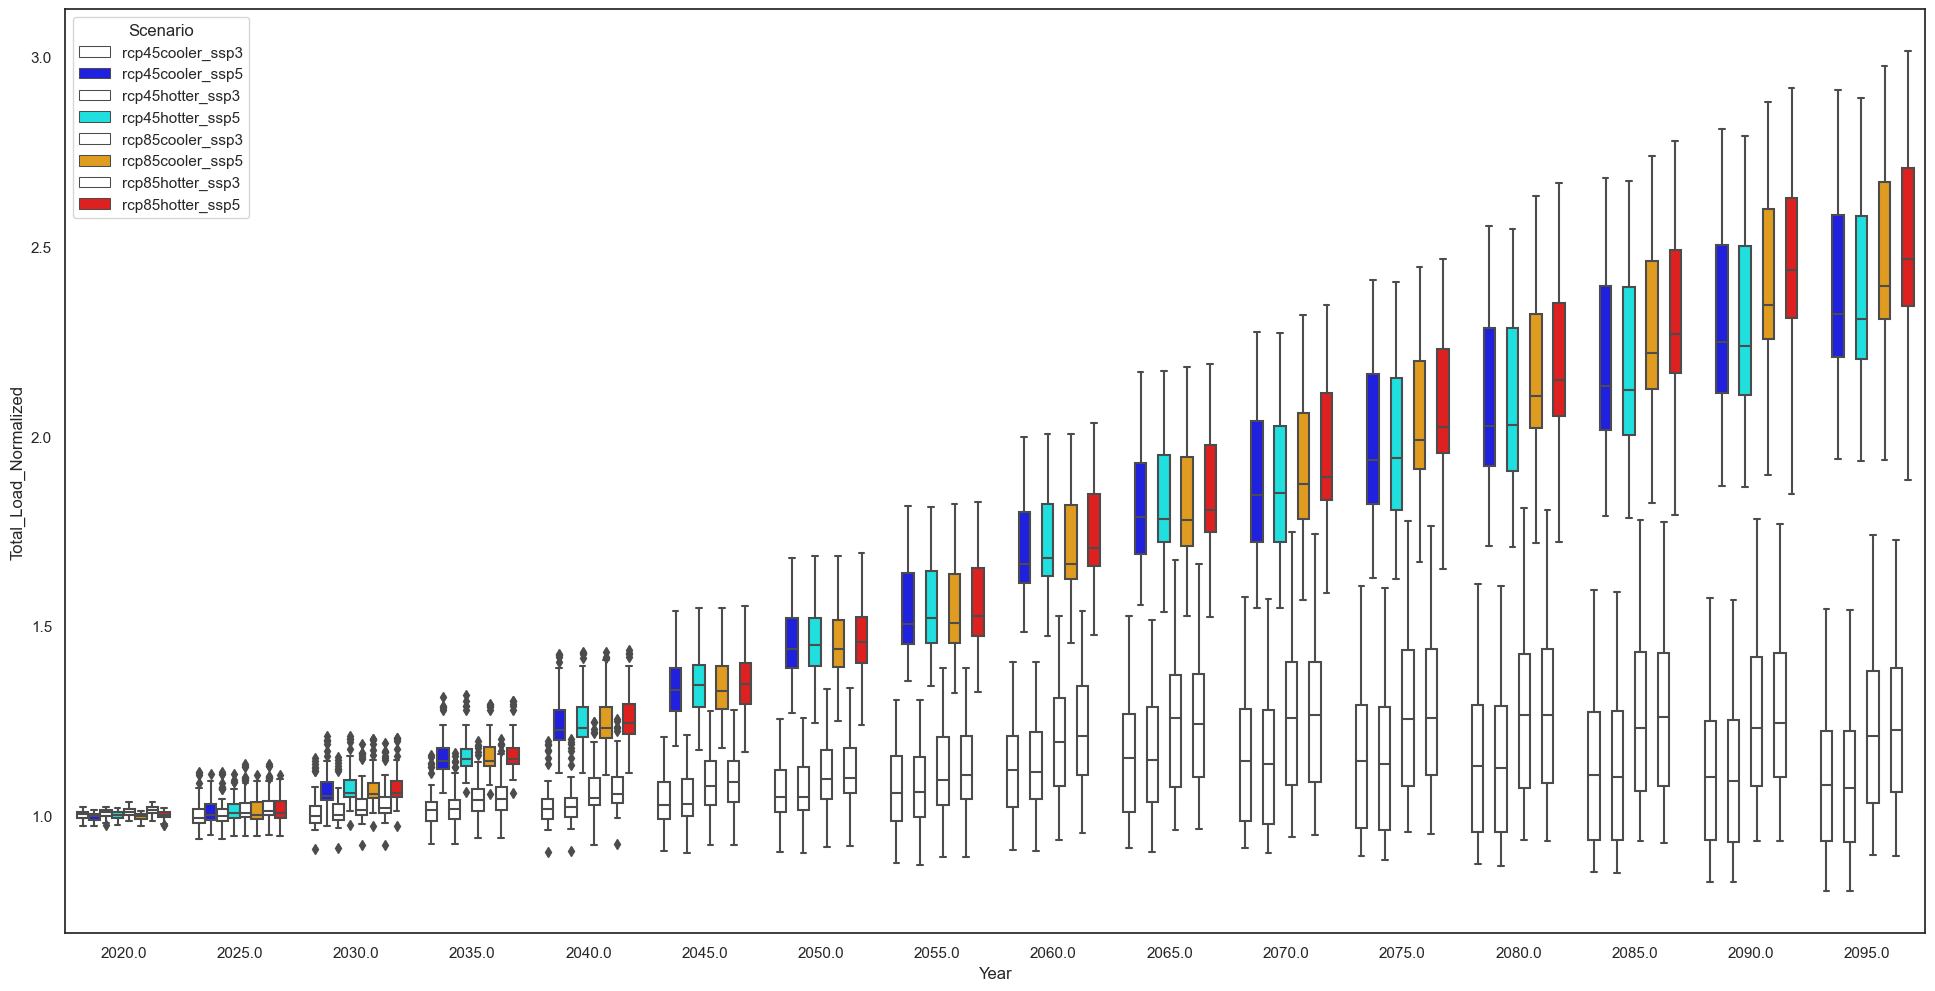

In [42]:
plot_state_load_box_plots(data_input_dir = data_output_dir, 
                          image_output_dir = image_output_dir, 
                          image_resolution = 50, 
                          save_images = True)


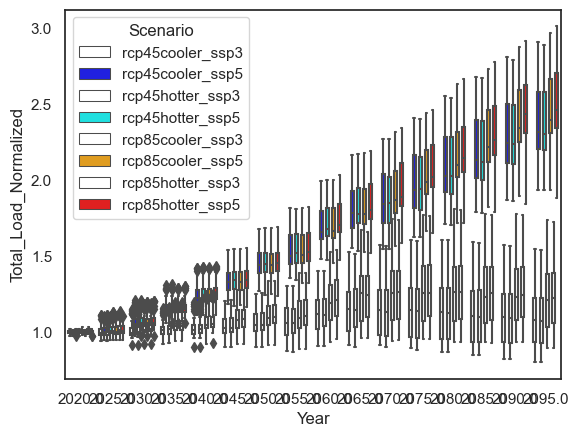